# Using Genex to identify marker genes

Top Genes Heatmap

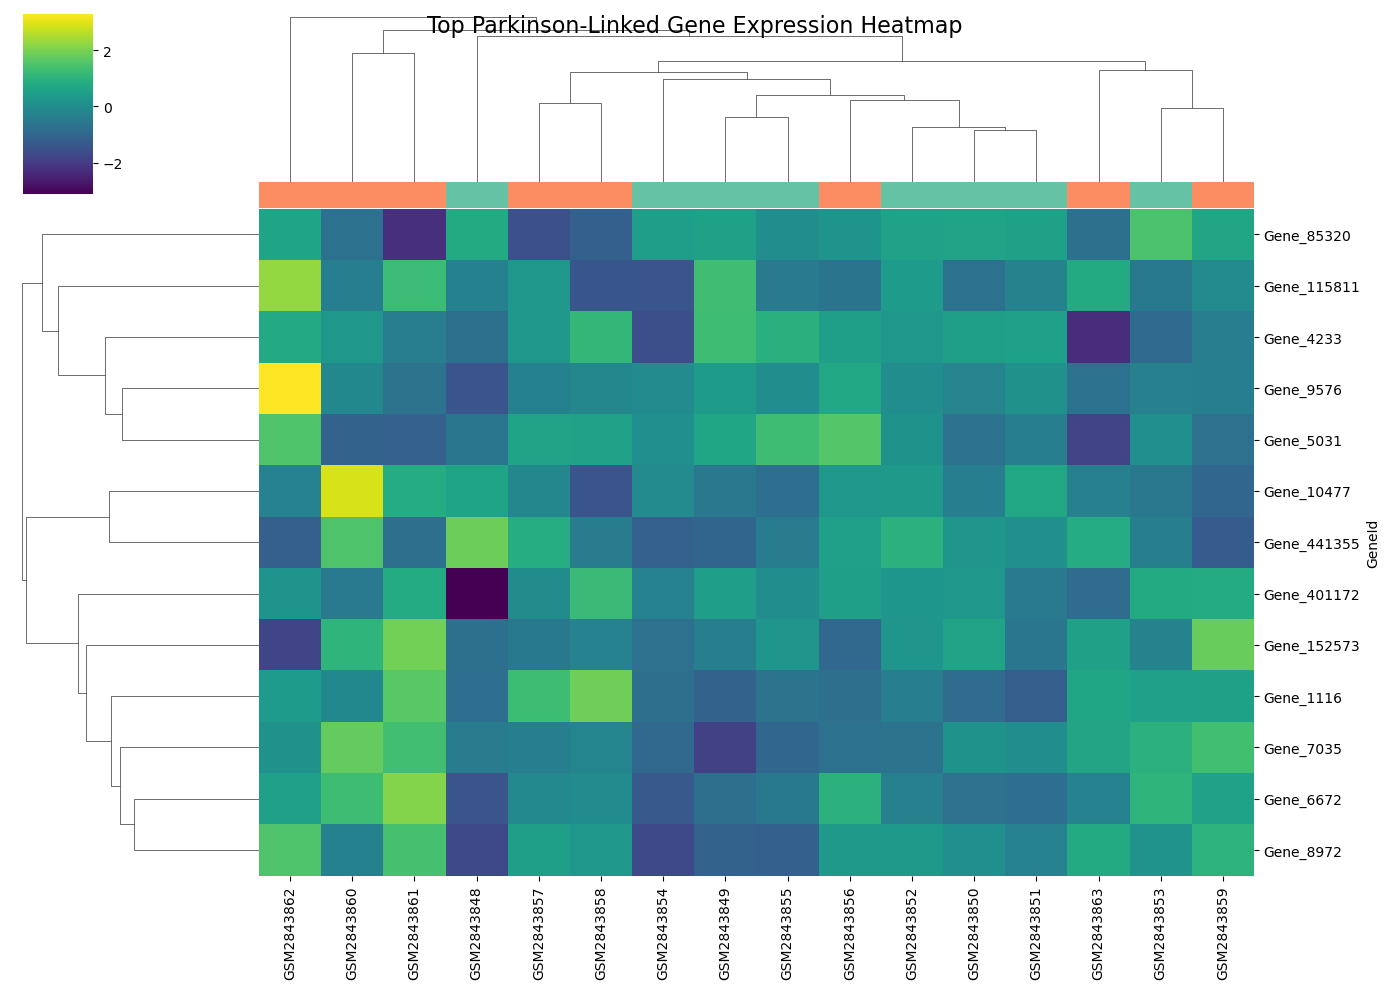

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load expression data with GeneId as index
mydata = 'GSE106608_norm'
data_file = './data/' + mydata + '.csv'
df = pd.read_csv(data_file, index_col=0)

# 2. Convert all expression values to numeric (in case of bad entries)
df = df.apply(pd.to_numeric, errors='coerce')

# 3. Select top Parkinson-linked genes
top_genes = [
    "Gene_115811", "Gene_85320", "Gene_105371648", "Gene_441355", "Gene_8972",
    "Gene_101928563", "Gene_105374317", "Gene_5031", "Gene_6672", "Gene_642946",
    "Gene_7035", "Gene_1116", "Gene_654463", "Gene_401172", "Gene_105374320",
    "Gene_105379869", "Gene_4233", "Gene_9576", "Gene_10477", "Gene_152573"
]

# 4. Subset the dataframe for these genes
heatmap_data = df.loc[df.index.intersection(top_genes)].dropna()

# 5. Normalize expression values (row-wise z-score)
heatmap_data_norm = (heatmap_data.subtract(heatmap_data.mean(axis=1), axis=0)
                                 .divide(heatmap_data.std(axis=1), axis=0))

# 6. Define sample conditions
samples = heatmap_data.columns.tolist()
conditions = ['Control'] * 8 + ['Parkinson'] * 8  # adjust if needed

# Sanity check
assert len(samples) == len(conditions), "Number of samples and conditions must match."

# 7. Create color labels for columns
condition_map = dict(zip(samples, conditions))
col_colors = [
    sns.color_palette("Set2")[0] if condition_map[sample] == "Control" else sns.color_palette("Set2")[1]
    for sample in samples
]

# 8. Plot clustered heatmap
sns.clustermap(
    heatmap_data_norm,
    cmap="viridis",
    col_colors=col_colors,
    figsize=(14, 10),
    xticklabels=True,
    yticklabels=True
)
plt.suptitle("Top Parkinson-Linked Gene Expression Heatmap", fontsize=16)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data (GeneId as index)
mydata = 'GSE106608_norm'
data_file = './data/' + mydata + '.csv'
df = pd.read_csv(data_file, index_col=0)

# 2. Convert expression values to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# 3. Transpose so that samples are rows, genes are columns (for plotting sample-wise)
df_t = df.T

# 4. Create a boxplot
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_t, orient='v')
plt.xticks(rotation=90)
plt.title("Gene Expression Distribution per Sample", fontsize=14)
plt.xlabel("Sample")
plt.ylabel("Expression Value")
plt.tight_layout()
plt.show()



In [59]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Load normalized expression data
df = pd.read_csv('./data/GSE106608_norm.csv', index_col=0)
df = df.apply(pd.to_numeric, errors='coerce')

# Define sample groups
control_samples = df.columns[:8]
disease_samples = df.columns[8:16]

# Initialize results list
results = []

# Loop through each gene
for gene in df.index:
    control_expr = df.loc[gene, control_samples].dropna()
    disease_expr = df.loc[gene, disease_samples].dropna()
    
    # Skip genes with missing values
    if len(control_expr) < 2 or len(disease_expr) < 2:
        continue

    # Calculate means
    mean_control = np.mean(control_expr)
    mean_disease = np.mean(disease_expr)

    # Fold Change and log2FC
    fc = mean_disease / mean_control if mean_control != 0 else np.nan
    log2fc = np.log2(fc) if fc > 0 else np.nan

    # Perform t-test
    t_stat, p_value = ttest_ind(disease_expr, control_expr, equal_var=False)

    results.append({
        "Gene": gene,
        "Mean_Control": mean_control,
        "Mean_Disease": mean_disease,
        "FoldChange": fc,
        "log2FoldChange": log2fc,
        "p_value": p_value
    })

# Convert to DataFrame
res_df = pd.DataFrame(results)

# Adjust p-values using Benjamini-Hochberg FDR
res_df['adj_p_value'] = multipletests(res_df['p_value'], method='fdr_bh')[1]

# Sort by adjusted p-value
res_df = res_df.sort_values(by='adj_p_value')

# Show top 10 genes
print(res_df[res_df['adj_p_value']<0.1].head(10))

# Save to CSV
res_df.to_csv('./data/deseq2_like_results.csv', index=False)


Empty DataFrame
Columns: [Gene, Mean_Control, Mean_Disease, FoldChange, log2FoldChange, p_value, adj_p_value]
Index: []


PermissionError: [Errno 13] Permission denied: './data/deseq2_like_results.csv'

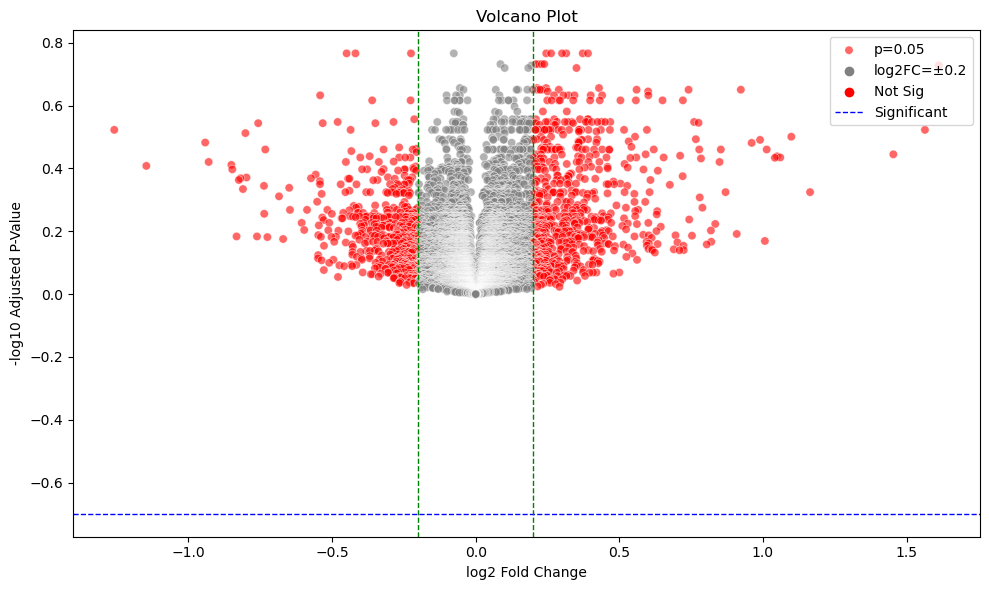

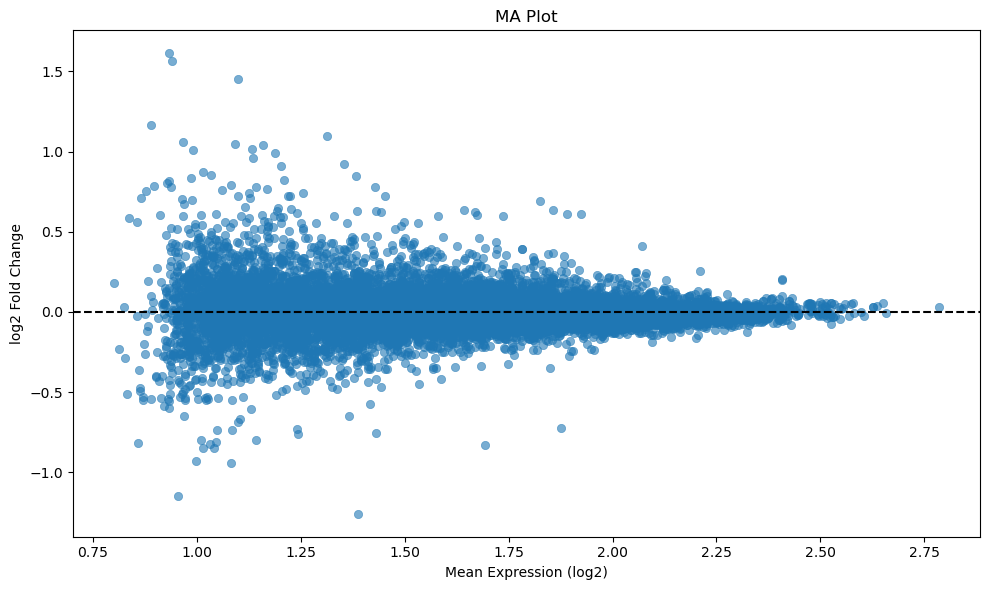

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Volcano plot
def plot_volcano(df, logfc_thresh=0.2, pval_thresh=5):
    df['-log10_pval'] = -np.log10(df['adj_p_value'])

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='log2FoldChange',
        y='-log10_pval',
        data=df,
        hue=(df['adj_p_value'] < pval_thresh) & (abs(df['log2FoldChange']) > logfc_thresh),
        palette={True: 'red', False: 'gray'},
        alpha=0.6
    )

    plt.axhline(-np.log10(pval_thresh), color='blue', linestyle='--', lw=1)
    plt.axvline(logfc_thresh, color='green', linestyle='--', lw=1)
    plt.axvline(-logfc_thresh, color='green', linestyle='--', lw=1)
    plt.title("Volcano Plot")
    plt.xlabel("log2 Fold Change")
    plt.ylabel("-log10 Adjusted P-Value")
    plt.legend(["p=0.05", f"log2FC=±{logfc_thresh}", "Not Sig", "Significant"], loc="upper right")
    plt.tight_layout()
    plt.show()


# MA plot
def plot_ma(df):
    df = df.copy()
    df['mean_expr'] = np.log2((df['Mean_Control'] + df['Mean_Disease']) / 2 + 1)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='mean_expr',
        y='log2FoldChange',
        data=df,
        alpha=0.6,
        edgecolor=None
    )
    plt.axhline(0, color='black', linestyle='--')
    plt.title("MA Plot")
    plt.xlabel("Mean Expression (log2)")
    plt.ylabel("log2 Fold Change")
    plt.tight_layout()
    plt.show()


# Run plots
plot_volcano(res_df)
plot_ma(res_df)


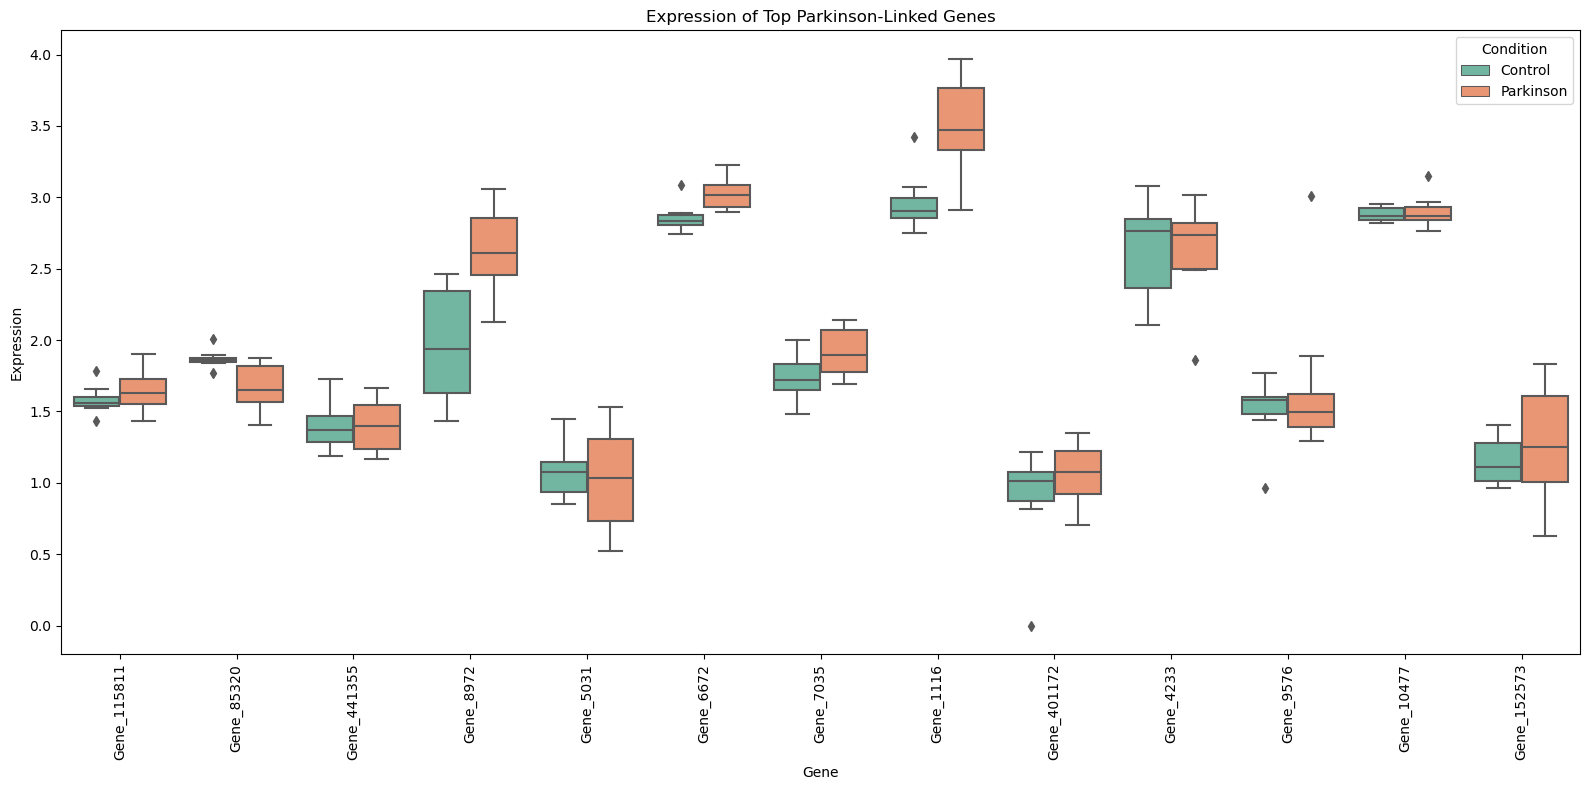

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load expression data (already normalized)
df = pd.read_csv('./data/GSE106608_norm.csv', index_col=0)
df = df.apply(pd.to_numeric, errors='coerce')

# Define top genes to visualize
top_genes = [
    "Gene_115811", "Gene_85320", "Gene_105371648", "Gene_441355", "Gene_8972",
    "Gene_101928563", "Gene_105374317", "Gene_5031", "Gene_6672", "Gene_642946",
    "Gene_7035", "Gene_1116", "Gene_654463", "Gene_401172", "Gene_105374320",
    "Gene_105379869", "Gene_4233", "Gene_9576", "Gene_10477", "Gene_152573"
]

# Define sample groups (adjust as needed)
samples = df.columns.tolist()
conditions = ['Control'] * 8 + ['Parkinson'] * 8
sample_map = dict(zip(samples, conditions))

# Prepare long-format DataFrame for seaborn boxplot
long_df = []
for gene in top_genes:
    if gene in df.index:
        for sample in samples:
            long_df.append({
                "Gene": gene,
                "Expression": df.loc[gene, sample],
                "Sample": sample,
                "Condition": sample_map[sample]
            })

long_df = pd.DataFrame(long_df)

# Plot: Boxplot of top genes by condition
plt.figure(figsize=(16, 8))
sns.boxplot(data=long_df, x='Gene', y='Expression', hue='Condition', palette="Set2")
plt.xticks(rotation=90)
plt.title("Expression of Top Parkinson-Linked Genes")
plt.tight_layout()
plt.show()


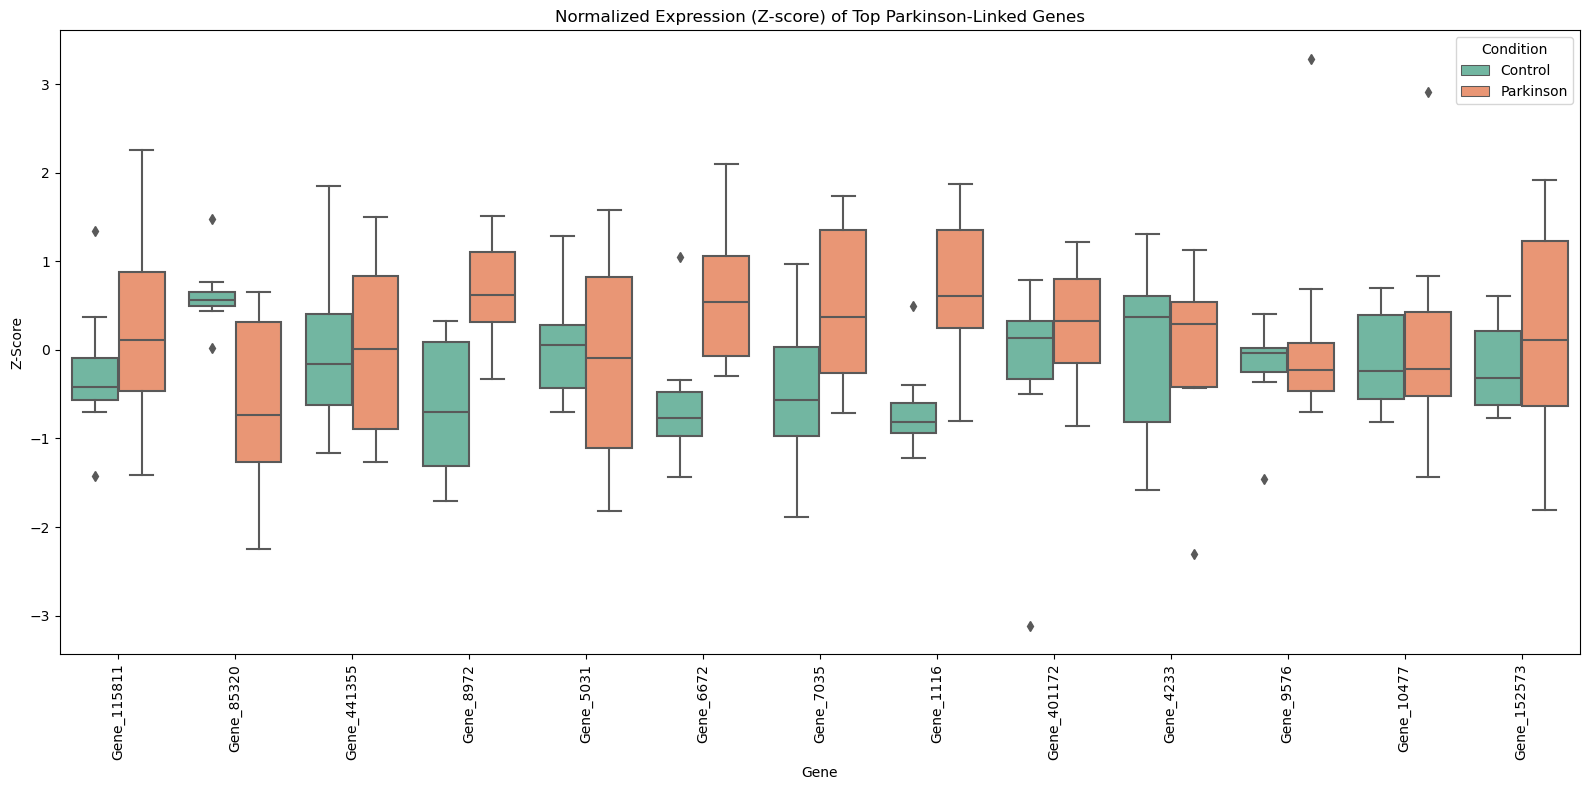

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_csv('./data/GSE106608_norm.csv', index_col=0)
df = df.apply(pd.to_numeric, errors='coerce')

# Define top genes (make sure these exist in your dataset)
top_genes = [
    "Gene_115811", "Gene_85320", "Gene_105371648", "Gene_441355", "Gene_8972",
    "Gene_101928563", "Gene_105374317", "Gene_5031", "Gene_6672", "Gene_642946",
    "Gene_7035", "Gene_1116", "Gene_654463", "Gene_401172", "Gene_105374320",
    "Gene_105379869", "Gene_4233", "Gene_9576", "Gene_10477", "Gene_152573"
]

# Keep only those genes present in the dataset
top_genes = [gene for gene in top_genes if gene in df.index]

# Z-score normalization per gene
df_norm = df.loc[top_genes].subtract(df.loc[top_genes].mean(axis=1), axis=0)
df_norm = df_norm.divide(df.loc[top_genes].std(axis=1), axis=0)

# Define sample labels
samples = df.columns.tolist()
conditions = ['Control'] * 8 + ['Parkinson'] * 8  # Adjust if your sample order differs
sample_map = dict(zip(samples, conditions))

# Convert to long format for seaborn
long_df = []
for gene in top_genes:
    for sample in samples:
        long_df.append({
            "Gene": gene,
            "Z-Score": df_norm.loc[gene, sample],
            "Sample": sample,
            "Condition": sample_map[sample]
        })

long_df = pd.DataFrame(long_df)

# Plot normalized box plots
plt.figure(figsize=(16, 8))
sns.boxplot(data=long_df, x='Gene', y='Z-Score', hue='Condition', palette="Set2")
plt.xticks(rotation=90)
plt.title("Normalized Expression (Z-score) of Top Parkinson-Linked Genes")
plt.tight_layout()
plt.show()


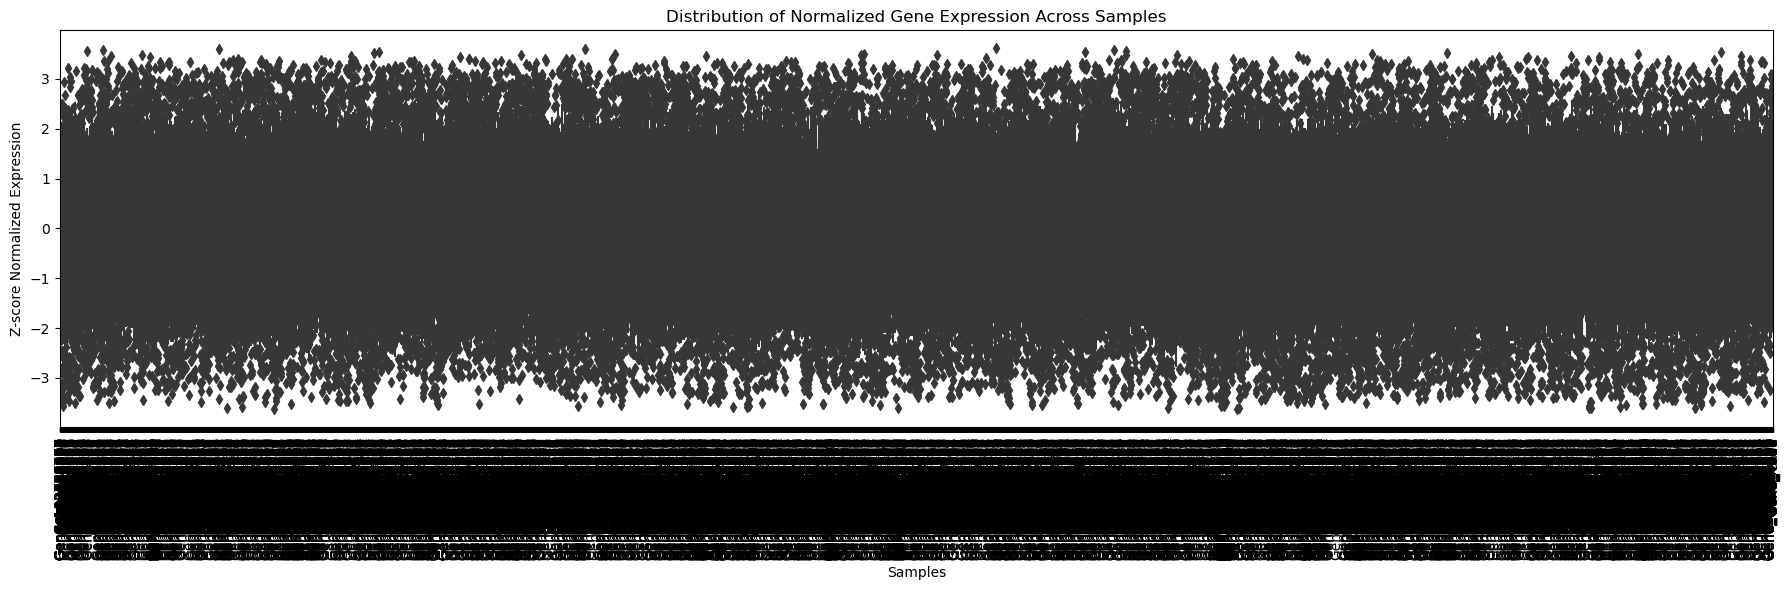

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean
df = pd.read_csv('./data/GSE106608_norm.csv', index_col=0)
df = df.apply(pd.to_numeric, errors='coerce')

# Z-score normalization per gene
df_norm = df.subtract(df.mean(axis=1), axis=0)
df_norm = df_norm.divide(df.std(axis=1), axis=0)

# Transpose for boxplot (genes collapsed, samples on x-axis)
df_t = df_norm.T

# Plot box plot per sample
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_t, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Distribution of Normalized Gene Expression Across Samples")
plt.ylabel("Z-score Normalized Expression")
plt.xlabel("Samples")
plt.tight_layout()
plt.show()
